# Predicting Tesla stock price with ARIMA

After trying to predict Tesla stock price with LSTM, we realised that that model is not the best for predicting Tesla's unexpected spike in the past year, based on training data from its earlier days.

We looked for better options and came across the ARIMA model (AutoRegressive Integrated Moving Average model). Apparently, the ARIMA model was designed for time series analysis and we decided to give it a go!


### Like always, lets start by importing the neccessary modules

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

<ipython-input-1-830c3a369e7a>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


### We meet again, Alpha Vantage API!

In [2]:
from alpha_vantage.timeseries import TimeSeries
API_KEY = 'ZLL997KKZMX2B4BL'
app = TimeSeries(API_KEY, output_format='pandas')

In [6]:
# Get daily adjusted stock information for Tesla, for the past 1259 days (about 3+ years)
TSLA = app.get_daily_adjusted('TSLA', outputsize='full')[0][:1259]
df = pd.DataFrame(TSLA)
df = df.iloc[::-1].reset_index()
df

,date,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
0,2016-04-18,252.23,258.3100,251.660,253.88,50.776,4271362.0,0.0,1.0
1,2016-04-19,253.12,254.3699,241.251,247.37,49.474,6357526.0,0.0,1.0
2,2016-04-20,246.26,253.6600,241.500,249.97,49.994,5194051.0,0.0,1.0
3,2016-04-21,248.99,250.9000,246.910,248.29,49.658,2783059.0,0.0,1.0
4,2016-04-22,248.89,254.0000,245.710,253.75,50.750,3786327.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
1254,2021-04-12,685.70,704.8000,682.090,701.98,701.980,29135670.0,0.0,1.0
1255,2021-04-13,712.70,763.0000,710.660,762.32,762.320,44652808.0,0.0,1.0
1256,2021-04-14,770.70,780.7900,728.030,732.23,732.230,49017434.0,0.0,1.0
1257,2021-04-15,743.10,743.6900,721.310,738.85,738.850,27848900.0,0.0,1.0


### We learned that ARIMA will be a good model if there is auto-correlation.

### Visualise the data to check if there is any auto-correlation.

Autocorrelation is a mathematical representation of the degree of similarity between a given time series and a lagged version of itself over successive time intervals. It is the same as calculating the correlation between two different time series, except autocorrelation uses the same time series twice: once in its original form and once lagged one or more time periods. 

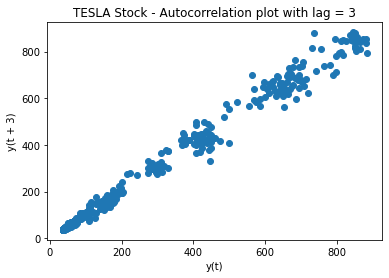

In [8]:
plt.figure()
lag_plot(df['5. adjusted close'], lag=3)
plt.title('TESLA Stock - Autocorrelation plot with lag = 3')
plt.show()

### As shown, the data seems to be quite linear and autocorrelated. Hence, ARIMA will be a good model to use!

### Now lets take a look again at TSLA's crazy ride over the past 4 years

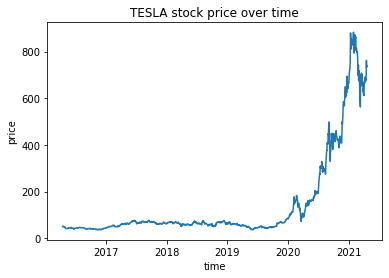

In [9]:
plt.plot(df["date"], df["5. adjusted close"])
plt.title("TESLA stock price over time")
plt.xlabel("time")
plt.ylabel("price")
plt.show()

### Now we start with the train/test split, followed by training the ARIMA model using the dependencies we have imported at the top.

In [10]:
train_data, test_data = df[0:int(len(df)*0.7)], df[int(len(df)*0.7):]
training_data = train_data['5. adjusted close'].values
test_data = test_data['5. adjusted close'].values
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(4,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)
MSE_error = mean_squared_error(test_data, model_predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))

/Users/bob/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
Testing Mean Squared Error is 378.97979991688516


## As printed, Testing Mean Squared Error (MSE) is 378.98, which is very very high!

### This means that accurate prediction is very hard. 

### Lets visualise the training results to see whether the prediction is truly inaccurate.

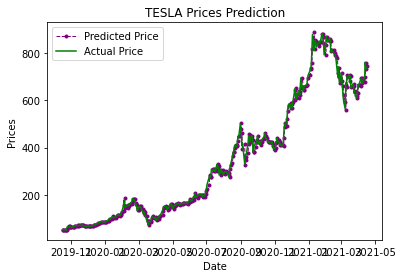

<Figure size 1440x720 with 0 Axes>

In [11]:
test_set_range = df['date'][int(len(df)*0.7):]
plt.plot(test_set_range, model_predictions, color='purple', marker='.', linestyle='dashed',label='Predicted Price', linewidth=1)
plt.plot(test_set_range, test_data, color='green', label='Actual Price')
plt.title('TESLA Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
# plt.xticks(np.arange(881,1259,50), df.date[881:1259:50])
plt.legend()
plt.figure(figsize=(20,10)) 
plt.show()

## As shown, the ARIMA model performs superbly well! It is able to follow the stock price's trend very closely. 

Even though at the extreme points (The VIX points as the pros call it) the accuracy of our model is very low, it still follows the overall trend closely. 

This should be considered a success considering our use case, which is to predict stock price in order to know when to invest and when to sell. Even though short-term predictions are inaccurate, this model can predict long term trends well and thus we can invest with more confidence knowing that our investment decisions are backed by data. 